In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import time
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import networkx as nx
import matplotlib.pyplot as plt

from pprint import pprint

import src
from src.reload import deep_reload

In [87]:
'''
Creating a random graph

graph contains n places and m charging stations - the random graph is completely connected
'''
deep_reload(src)

# Parameters for graph creation
seed = 125396749 # RNG seed [-]
n = 15 # Number of places [-]
m = 85 # Number of stations [-]
speeds = [105 / 3.6] # Set of speeds to be assigned to links [m/s]
chargers = list(range(10)) # Set of numbers of chargers to be assigned to stations [-]
scale = (1e6, 1e6) # Scale of the area on which the graph is generated ([m], [m])

# Setting the graph as directed
kw = {
    'graph': {
        'directed': True,
    },
}

# Creating the graph
graph = src.rng.random_completely_connected_graph(
    n, m, speeds = speeds, scale = scale, seed = seed, chargers = chargers, **kw
)

# Marking the edge types by source and target type
graph = src.routing.edge_types(graph)

In [109]:
def get_stations_utilized(paths):

    stations_utilized = []

    for destination, path in paths.items():

        if 'place' in destination:

            stations_utilized.extend(path[1:-1])

    return list(np.unique(stations_utilized))

In [113]:
deep_reload(src)

seed = 1468952
seed = None
rng = np.random.default_rng(seed)

vehicle_param = src.experiments._vehicle_kwargs
vehicle_param['capacity'] = 40 * 3.6e6
station_param = src.experiments._station_kwargs
# station_param['station']['setup_time'] = 0
graphs = [0]

graph_index, vehicle_kw, station_kw = src.experiments.generate_case(
    graphs, vehicle_param, station_param, rng,
)

vehicle_kw

{'capacity': 144000000.0,
 'power': 108722.88314619556,
 'risk_attitude': array([0.54803153, 0.74803153]),
 'cases': 30,
 'soc_bounds': (0.1, 1),
 'efficiency': 550,
 'linear_fraction': 0.8}

In [116]:
deep_reload(src)

origins = ['place_0']
destinations = [k for k in graph.nodes if 'station' not in k]
vehicle_kw['risk_attitude'] = (.8, .99)
# vehicle_kw['risk_attitude'] = (0, .2)

vehicle = src.routing.Vehicle(**vehicle_kw)
graph = src.routing.supply_costs(graph, vehicle, station_kw)

# costs, values, paths = src.routing.shortest_paths(
#     graph, origins,
#     objective = vehicle,
#     method = 'dijkstra',
# )

# expected_impedance = src.routing.specific_impedance(
#     values) / 3600

impedances = []

stations_utilized_ind = []

for idx in range(vehicle.cases):

    vehicle = vehicle.select_case(idx)

    costs, values, paths = src.routing.shortest_paths(
        graph, origins,
        objective = vehicle,
        method = 'dijkstra',
        destinations = destinations
    )

    impedances.append(src.routing.specific_impedance(
        values, field = 'delay_time') / 3600)

    stations_utilized_ind.extend(get_stations_utilized(paths))

mean_impedance = np.mean(impedances)
stations_utilized_ind = np.unique(stations_utilized_ind)

graph = src.routing.expect_supply_costs(graph)

costs, values, paths = src.routing.shortest_paths(
    graph, origins,
    objective = vehicle,
    method = 'dijkstra',
    destinations = destinations
)

expected_impedance = src.routing.specific_impedance(values, field = 'delay_time') / 3600
stations_utilized_exp = np.array(get_stations_utilized(paths))

In [117]:
mean_impedance, expected_impedance, (expected_impedance - mean_impedance) / expected_impedance

(0.21709545986350332, 0.22809881443043584, 0.04823942024603664)

In [118]:
stations_utilized_ind, stations_utilized_exp

(array(['station_1', 'station_14', 'station_15', 'station_2', 'station_22',
        'station_3', 'station_37', 'station_46', 'station_48',
        'station_49', 'station_64', 'station_65', 'station_69',
        'station_72', 'station_73', 'station_76', 'station_82',
        'station_84'], dtype='<U10'),
 array(['station_1', 'station_15', 'station_2', 'station_22', 'station_3',
        'station_37', 'station_46', 'station_48', 'station_49',
        'station_64', 'station_65', 'station_69', 'station_72',
        'station_73', 'station_76', 'station_82', 'station_84'],
       dtype='<U10'))

In [121]:
{'a': 1} + {'b': 2}

TypeError: unsupported operand type(s) for +: 'dict' and 'dict'

In [122]:
class Hasher(dict):
    # https://stackoverflow.com/a/3405143/190597
    def __missing__(self, key):
        value = self[key] = type(self)()
        return value

a = Hasher()

a['d']['c']

{}

In [57]:
graph._adj['station_0']['station_1']

{'distance': 335964.7428208848,
 'time': 11518.791182430337,
 'price': 0,
 'type': 'to_station',
 'feasible': False,
 'energy': 184780608.55148664,
 'charging_time': 17767.38761061039,
 'delay_time': 339.4419891109421,
 'total_time': 29625.62078215167,
 'routing_time': 29625.62078215167}

In [107]:
costs, values, paths = src.routing.shortest_paths(
    graph1, origins,
    objective = vehicle,
    method = 'dijkstra',
)

src.routing.specific_impedance(values) / 3600

6.7631390983944755

In [199]:
deep_reload(src)

vehicle_kw['risk_attitude'] = (.8, .99)
vehicle_kw['risk_attitude'] = (.01, .2)

vehicle = src.routing.Vehicle(**vehicle_kw)
# vehicle = vehicle.select_case(8)

t0 = time.time()

origins = ['place_0']

costs, values, paths = src.routing.shortest_paths(
    graph, origins,
    objective = vehicle,
    method = 'dijkstra',
)

print(src.routing.specific_impedance(values, expectation = vehicle.expectation) / 3600)

print(f'Executed in {time.time() - t0:.4f} seconds')

6.445970471859946
Executed in 1.0824 seconds


In [198]:
deep_reload(src)

vehicle_kw['risk_attitude'] = (.8, .99)
# vehicle_kw['risk_attitude'] = (.01, .2)

vehicle = src.routing.Vehicle(**vehicle_kw)
# vehicle = vehicle.select_case(8)

t0 = time.time()

origins = ['place_0']

costs, values, paths = src.routing.shortest_paths(
    graph, origins,
    objective = vehicle,
    method = 'dijkstra',
)

print(src.routing.specific_impedance(values, expectation = vehicle.expectation) / 3600)

print(f'Executed in {time.time() - t0:.4f} seconds')

6.450115701243298
Executed in 1.1025 seconds


In [92]:
deep_reload(src)

vehicle_kw['cases'] = 1
vehicle = src.routing.Vehicle(**vehicle_kw)

t0 = time.time()

origins = ['place_0']

graph1 = src.routing.supply_costs(graph.copy(), vehicle, station_kw)

costs, values, paths = src.routing.shortest_paths(
    graph1, origins,
    objective = vehicle,
    method = 'dijkstra',
)

print(src.routing.specific_impedance(values) / 3600)

print(f'Executed in {time.time() - t0:.4f} seconds')

6.763139098394473
Executed in 0.7775 seconds


In [91]:
deep_reload(src)

vehicle = src.routing.Vehicle(**vehicle_kw)
vehicle = vehicle.select_case(5)

t0 = time.time()

places = [k for k, v in graph._node.items() if v['type'] is 'place']
origins = [places[0]]

# graph = src.routing.supply_costs(graph, vehicle, station_kw)

costs, values, paths = src.routing.shortest_paths(
    graph, origins,
    objective = vehicle,
    method = 'dijkstra',
)

print(src.routing.specific_impedance(values) / 3600)

print(f'Executed in {time.time() - t0:.4f} seconds')

6.71537568301511
Executed in 0.0289 seconds


In [63]:
f = lambda x: x[min([len(x) - 1, case])]
case = 5

f([1, 4])

4

In [64]:
a = [1, 2, 3]
a[case % len(a)]

3

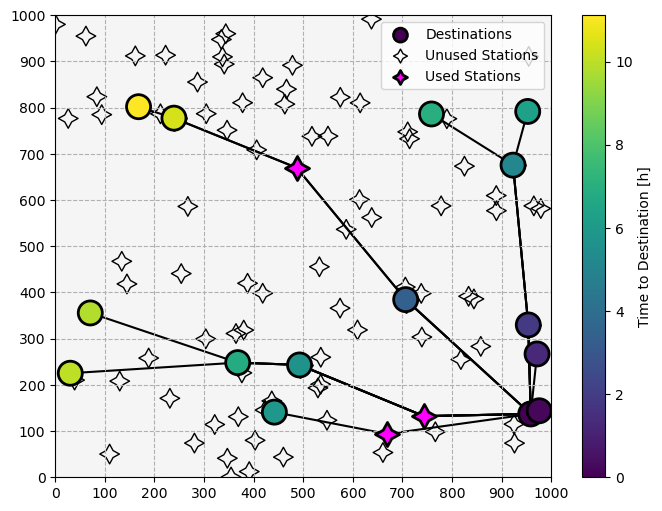

In [31]:
'''
Plotting the optimal paths
'''
deep_reload(src)

fig, ax = plt.subplots(figsize = (8, 6))

destinations = [k for k, v in graph._node.items() if v['type'] is 'place']

kw = src.figures.default_route_tree_kwargs

src.figures.plot_route_tree(
    ax, graph,
    values = {k: v['total_time'].mean() / 3600 for k, v in values.items()},
    paths = {k: v for k, v in paths.items() if graph._node[k]['type'] is 'place'},
    destinations = destinations,
    **kw,
)

_ = ax.set(**{
    'xticks': np.linspace(-5e5, 5e5, 11),
    'xticklabels': np.linspace(0, 1e3, 11, dtype = int),
    'xlim': (-5e5, 5e5),
    'yticks': np.linspace(-5e5, 5e5, 11),
    'yticklabels': np.linspace(0, 1e3, 11, dtype = int),
    'ylim': (-5e5, 5e5),
    'facecolor': 'whitesmoke',
})

legend = ax.legend()

for h in legend.legendHandles:
    h._sizes = [100]

    ax.grid(ls = '--')